# INTRODUCTION TO SQL ON POSTGRESQL SERVER

**BY SERHAT ÇEVİKEL**

In today's session, we will be continuing from where we left:

- We explored the data
- We transformed the data
- Now we will start the postgresql daemon
- Create a database
- Import data into it
- Start querying the database

For simplicity purposes and due to time/resource constraints, we will import and set primary keys on only selected few tables

We will skip the melting of tables, a task for which we provided an example before

We already have a complete working database as imdb2

First as we did before, we unzip the gzipped tsv files and trim the header rows, since PostgreSQL do not allow for header rows while importing tsv files according to [its own documentation on the COPY Command](https://www.postgresql.org/docs/current/static/sql-copy.html)

>HEADER

>    Specifies that the file contains a header line with the names of each column in the file. On output, the first line contains the column names from the table, and on input, the first line is ignored. This option is allowed only when using CSV format.


One option might be to convert a tsv into a csv by translating tab characters to commas using "sed" or better "tr". We will also use this option for selected tables

## From the shell to PostgreSQL

### Start the postgresql daemon on the background

Since that may take some time between 5-10 minutes in our binder environment, it is better that we do it now, so that we can proceed with file operations without waiting for the daemon to start:

In [ ]:
/usr/lib/postgresql/11/bin/pg_ctl start -D /etc/postgresql/11/main/ -m smart

If an error is returned, you should rerun the cell.

We can check whether the daemon has started with:

In [ ]:
psql -U postgres -c "\l"

This will list all databases on our server

Until this command returns something successfully, the PostgreSQL server will not respond.

But until we reach 1.2, we do not need to connect to the PostgreSQL server.

### Environment variables

First, declare the environment variables for paths

In [ ]:
datadir=~/data
imdbdir=$datadir/imdb

### Unzip the gzipped files and trim headers

Then create the directory for unzipped files:

In [ ]:
mkdir -p $imdbdir/tsv2

And unzip the files if they do not exist yet:

In [ ]:
find $imdbdir/tsv -mindepth 1 | \
    parallel -k -j0 "basenm=\$(basename {});
        if [ ! -e ${imdbdir}/tsv2/\${basenm%.gz} ];
        then
            gunzip -c {} > \
            ${imdbdir}/tsv2/\${basenm%.gz};
        fi
        "

the "basename" function extracts the filename portion from the full path name so we can reproduce the full path name under another directory

In [ ]:
tldr basename

The ```${basenm%.gz}``` portion is a form of "parameter substitution"

It means:

> \\${var%Pattern}, \\${var%%Pattern}

> \\${var%Pattern} Remove from \\$var the shortest part of \\$Pattern that matches the back end of \\$var.


> \\${var%%Pattern} Remove from \\$var the longest part of \\$Pattern that matches the back end of \\$var.

(https://www.tldp.org/LDP/abs/html/parameter-substitution.html)

Now let's check whether the gunzipped files are there:

In [ ]:
ls -l $imdbdir/tsv2

Now we will trim the first lines and dump into a new directory named tsv3.

In [ ]:
mkdir -p $imdbdir/tsv3

In [ ]:
find $imdbdir/tsv2 -mindepth 1 | \
    parallel -k -j0 "basenm=\$(basename {});
        if [ ! -e ${imdbdir}/tsv3/\${basenm/.tsv/2.tsv} ];
        then
            tail -n+2 {} > \
            ${imdbdir}/tsv3/\${basenm/.tsv/2.tsv};
        fi
        "

"basenm/.tsv/2.tsv" part is like the substitution command of sed: find ".tsv" and replace with "2.tsv"

"-e" checks the existence of the file and proceeds only if the file does not exist yet

Check whether row counts are decremented:

In [ ]:
find $imdbdir/tsv2 -mindepth 1 | \
    parallel -k -j0 "basenm=\$(basename {});
        {
            printf '%s\t' \$basenm;
            cat $imdbdir/tsv2/\$basenm | wc -l;
            cat $imdbdir/tsv3/\${basenm/.tsv/2.tsv} | wc -l;
        } | tr '\n' '\t' | xargs echo -e
        " | column -t

### Convert tsv's to csv's

Now let's convert tsv's to csv's

In [ ]:
mkdir -p $imdbdir/csv

In [ ]:
find $imdbdir/tsv2 -mindepth 1 | \
    parallel -k -j0 "basenm=\$(basename {});
        if [ ! -e ${imdbdir}/csv/\${basenm/.tsv/.csv} ];
        then
            cat {} | tr '\t' ',' > \
            ${imdbdir}/csv/\${basenm/.tsv/.csv};
        fi
        "

List the csv directory

In [ ]:
ls -l $imdbdir/csv

And view the head of a file with column command, with "," as the separator/delimiter character:

In [ ]:
head $imdbdir/csv/name.basics.csv | column -t -s ","

We can also use the csv files to create the database 

### Ways to access the postgresql server

Remember we probed whether postgresql server is listening by:

In [ ]:
psql -U postgres -c "\l"

psql is the built-in interactive terminal client for PostgreSQL. It can both be used interactively with it shell or non-interactively with the "-c" (command) flag as we used above 

In [ ]:
tldr psql

psql is good for embedding sql codes in shell scripts. However for interactive purposes, it does not provide much features.

A better option is the "pgcli" interface. It is a part of the dbcli project, that provides better command line interfaces (CLI) as DBclients:

https://github.com/dbcli/pgcli

https://www.pgcli.com/

Now let's open a terminal from inside Jupyter/binder by clicking on the plus sign - the new launcher - to the left of the toolbar and click on the black terminal icon with the \$ sign:

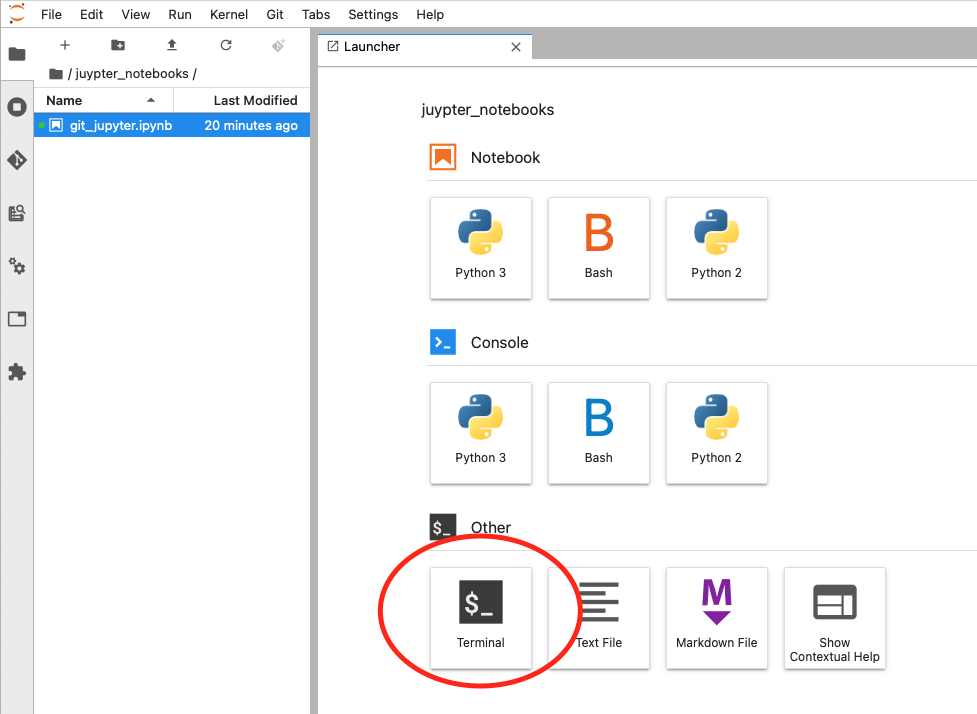

Now please copy and paste the below command inside that terminal:

```Bash
screen -S 1
```

In [ ]:
scr=$(screen -ls | grep -P "Attached" | head -1 | grep -Po "^\t+.+?(?=\s|\t)" | tr -d "\t")
screen -S $scr -X stuff "pgcli -U postgres\n"

Some options are automatically selected at build time.

- Auto completion is on
- Multiline mode is on: Statements canbe multiline, to execute them, put a semi-colon ";" at the end
- Vi-mode is on: If you are fluent at using vim editor, the same key bindings apply now

We may be using other interfaces, and here we will prefer to execute our commands through the Jupyter notebook. However, it is better to have pgcli opened on the terminal, since the smart completion facility makes it easier to write SQL statements. You can copy the statement to the Jupyter cells to be executed

Another client is pgAdmin4. It had a GUI interface before, but now it only works on web mode, hosted by your web browser - just as Jupyter is.

Due to limitations of the binder environment, we won't be using pgAdmin4 but you can check it from https://www.pgadmin.org/

There are several ways to access postgresql server from the Jupyter:

- Use bash kernel and send SQL commands via the "-c" flag of psql client
- Use SQL kernel of the beakerx project
- Use sql magic of python kernel through ipython_sql extension
- Use postgres_kernel
- Use any of the kernels through SoS kernel which is polyglot - each cell can be run on a separate kernel, which we do now

SQL kernel of beakerx extension is the most visually appealing and easy to use one, when used as a stand-alone notebook. However it does not play well from inside an SoS notebook, and we prefer the "polyglot" nature of the SoS notebook

postgres_kernel is buggy

So we will either use the sql magic on Python3 kernel or psql in non-interactive mode on bash_kernel

## Create a table space and a database

For the rest of the commands to work, PostgreSQL server should be listening on port 5432. Let's check:

In [ ]:
psql -U postgres -c "\l"

If the command does not list  the existing databases, we wait until it does so by re-running the cell. 

Hopefully, we started the database daemon back in the beginning of the session.

First we will create a tablespace - a directory on the filesystem for the PostgreSQL server to store our new database:


>22.6. Tablespaces
>
>Tablespaces in PostgreSQL allow database administrators to define locations in the file system where the files representing database objects can be stored. Once created, a tablespace can be referred to by name when creating database objects.
>
>By using tablespaces, an administrator can control the disk layout of a PostgreSQL installation. This is useful in at least two ways. First, if the partition or volume on which the cluster was initialized runs out of space and cannot be extended, a tablespace can be created on a different partition and used until the system can be reconfigured.

(https://www.postgresql.org/docs/current/static/manage-ag-tablespaces.html)

Create a directory on the filesystem:

In [ ]:
mkdir -p /pg1

Check the user and group ownership with the stat command:

In [ ]:
stat -c "%U %G" /pg1

In [ ]:
tldr stat

And make it owned by postgres user:

In [ ]:
chown -R jovyan:jovyan /pg1

And check again:

In [ ]:
stat -c "%U %G" /pg1

Note that, in this binder image, sudoer (admin) jovyan user becomes sudo without password prompt. This is for the non-interactive feature of bash_kernel on Jupyter (it cannot prompt for a password) and for better scriptability.

This environment is a short lived container isolated from the rest of the operating system it sits atop. This feature should not be done in a production environment

Let's check again whether our postgresql server responds to our requests:

Now it is time to create a tablespace on /pg location and create a database there:

Let's review the list of databases again:

In [ ]:
psql -U postgres -c "\l"

First let's enable the sql magic on python kernel, so that we can send SQL commands to the PostgreSQL server easily with minimal additional syntax (using psql from the bash is another option):

In [ ]:
%load_ext sql

And create a connection with our server into the maintenance database "postgres":

In [ ]:
%sql postgres://postgres@localhost/postgres

Now from inside the Python3 kernel, we can execute sql statements easily if we insert a "%%sql" magic in the first line as such:

Comments start with "--"

Statements end with ";"

First let's create a tablespace "pg1" on our /pg1 directory: (we need the END; statement so that tablespace creation is executed without error)

In [ ]:
%%sql
-- create a new tablespace
END;
CREATE TABLESPACE pg1 LOCATION '/pg1';

And let's create a database on pg1 tablespace.

Note that, since we already have the "imdb" database, we will create imdb1 for practice purposes.

In [ ]:
%%sql
-- create a new database imdb1 on pg1 tablespace
END;
CREATE DATABASE imdb1
TABLESPACE = pg1;

Now connect to the new imdb1 database

In [ ]:
%sql postgres://postgres@localhost/imdb1

### Create and copy data into title_ratings table

Make sure we are connected to the newly created imdb1 database:

In [ ]:
%sql postgres://postgres@localhost/imdb1

And create a new table title_ratings with defined fields and types

Note that, we cannot use "." dot inside table and field names

In [ ]:
%%sql
-- create a new table
CREATE TABLE title_ratings
(
  tconst text,
  averageRating numeric,
  numVotes integer
);

In order to copy files from the local filesystem into the postgresql server, it is best to use the psql command:

In [ ]:
 psql -U postgres -d imdb1 -c "\copy title_ratings from $imdbdir/tsv3/title.ratings2.tsv"

Note that this runs the COPY command of SQL under the hood, however it does not fall onto file read privilege problems:



>Assuming the psql command-line tool, you may use \copy instead of copy.
>
>\copy opens the file and feeds the contents to the server, whereas copy tells the server the open the file itself and read it, which may be problematic permission-wise, or even impossible if client and server run on different machines with no file sharing in-between.
>
>Under the hood, \copy is implemented as COPY FROM stdin and accepts the same options than the server-side COPY.
>

(https://stackoverflow.com/questions/19463074/postgres-error-could-not-open-file-for-reading-permission-denied#19466558)

Another advantage of using the "\copy" syntax through psql on Bash is that we can easily pass environment variables such as $imdbdir

Now we can check the table exists by using psql meta-command to describe the tables inside a database:

In [ ]:
psql -U postgres -d imdb1 -c "\dt+"

And get the size of the database:

In [ ]:
%%sql
SELECT pg_size_pretty(pg_database_size('imdb1'));

Create, insert and drop operations after some time may leave a junk space inside the database. In this case, it is better to run the "vacuum" command:

In [ ]:
%%sql
VACUUM FULL;

Now let's view the data:

In [ ]:
%%sql
SELECT *
FROM title_ratings
LIMIT 5;

To delete the data inside a table we can either use "DELETE or TRUNCATE statements:

In [ ]:
%%sql
DELETE FROM title_ratings;

Now check whether data is deleted:

In [ ]:
%%sql
SELECT *
FROM title_ratings
LIMIT 5;

Now let's copy the data again, this time using the sql command COPY instead of psql built-in \copy:

In [ ]:
%%sql
COPY title_ratings from '/home/jovyan/data/imdb/tsv3/title.ratings2.tsv'

In [ ]:
%%sql
SELECT *
FROM title_ratings
LIMIT 5;

And delete data with TRUNCATE:

In [ ]:
%%sql
TRUNCATE title_ratings;

In [ ]:
%%sql
SELECT *
FROM title_ratings
LIMIT 5;

Check the size and vacuum:

In [ ]:
%%sql
SELECT pg_size_pretty(pg_database_size('imdb1'));

In [ ]:
%%sql
VACUUM FULL;

In [ ]:
%%sql
SELECT pg_size_pretty(pg_database_size('imdb1'));

### Primary keys

Now copy the data again using "\copy" meta-command of psql:

In [ ]:
psql -U postgres -d imdb1 -c "\copy title_ratings from $imdbdir/tsv3/title.ratings2.tsv"

Let's report the total row count using countrows alias. Note that "count()" is an example of the aggregate functions to summarize data:

Note that we define an alias "countrows" for the aggregate calculation we do after SELECT:

In [ ]:
%%sql
SELECT count(*) as countrows
FROM title_ratings;

More info on aggregate functions at:

https://www.postgresql.org/docs/current/static/functions-aggregate.html

And alias topic is covered in:

https://www.postgresql.org/docs/10/static/queries-table-expressions.html

Now, with a mistake, run the COPY query again! (either with psql's \copy or sql COPY) 

In [ ]:
%%sql
COPY title_ratings
FROM '/home/jovyan/data/imdb/tsv3/title.ratings2.tsv';

In [ ]:
%%sql
SELECT count(*) as countrows
FROM title_ratings;

We have twice the number of rows now, because postgresql did not complain to duplicate the same data!

We should define a primary key on the table and put a constraint on the uniqueness of that key
 But no problem we can ALTER anything in the table after it is first created:

In [ ]:
%%sql
ALTER TABLE title_ratings
ADD CONSTRAINT title_ratings_pk 
PRIMARY KEY (tconst);

It threw an integrity error: The data are duplicated and a primary key cannot have duplicate values!

Now let's drop the table alltogether (not delete the contents):

In [ ]:
%%sql
DROP TABLE title_ratings;

Create the table again with the constraint:

In [ ]:
%%sql
-- create a new table
CREATE TABLE title_ratings
(
  tconst text,
  averageRating numeric,
  numVotes integer,

CONSTRAINT title_ratings_pk
   PRIMARY KEY (tconst)
    
);

And import data:

In [ ]:
%%sql
COPY title_ratings
FROM '/home/jovyan/data/imdb/tsv3/title.ratings2.tsv';

Get the row count:

In [ ]:
%%sql
SELECT count(*) as countrows
FROM title_ratings;

And try to import the data again:

In [ ]:
%%sql
COPY title_ratings
FROM '/home/jovyan/data/imdb/tsv3/title.ratings2.tsv';

It did not allow us because uniqueness constraint prevented us to create duplicate values of primary key fields

**EXERCISE 1:**

Import the title.episode2.tsv into title_episode table in imdb2 database

- First create the table and the fields with appropriate types, including the primary key
- Then import the data

Remember the structure of title.episode:

- title.episode.tsv: 72 MB, 2,986,926 lines, 4 fields. Contains the tv episode information. Fields include:
- tconst (string) - alphanumeric identifier of episode
- parentTconst (string) - alphanumeric identifier of the parent TV Series
- seasonNumber (integer) – season number the episode belongs to
- episodeNumber (integer) – episode number of the tconst in the TV series.

Note that, -- defines a commented line not to be executed

And always finish your statements with a semicolon ";"

In [ ]:
%%sql

-- type your statement here

In [ ]:
psql -U postgres -d imdb1 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 1:**

In [ ]:
pass1=
encrypt="U2FsdGVkX19fL3ZRoTCbtF1KZ9onuO616t3++mXfoHW6bGrMWcoRBDrUBk/YM5VJ j88eS5+6fA4oYm0V96zw4/9qzgBW4Gu594+lLxW/TQ9xqzODOyRi4j4pIAXIffP0 yrMiwyscX8n20jTEINctgC8/eM6rxM+C+zforrKwZWt0lcxbOarz8OqWZDn8MhRk k0piDCSrj3m4S/tLMl9VJNPwCxLe+RAEmjbCHbMlV+kEcsi6WyfuZhj34UE8H1V2 9/4w8ILi5Z9uJkgaAmEl1RUUHzGKCiNxelC3l2H3xfcjk+QGRZAzodtHEBOLVKoz e+trtOLlLeaaSt4dlz/c02uYecdHchRwqhdonZQVoaYfDZMnJoLMvDY8O//9KAfJ"
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

## Meta-commands

psql and pgcli clients offer some meta-commands that start with "\" and that offer shortcuts to some common operations

You can get help on that using "\?" - a meta-command itself

In [ ]:
psql -U postgres -c "\?"

"\l" lists databases:

In [ ]:
psql -U postgres -c "\l"

"\c" connects to database:

In [ ]:
psql -U postgres -c "\c imdb2"

"\dt" lists tables in a database:
"\dt+" gives more detail

In [ ]:
psql -U postgres -d imdb2 -c "\dt+"

"\d" lists fields in a table

"\d+" gives more detail:

In [ ]:
psql -U postgres -d imdb2 -c "\d+ title_basics"

To get detailed information on all tables and primary keys in the public schema (like a named directory of databases, tables and keys)

In [ ]:
psql -U postgres -d imdb2 -c "\d+ public.*"

And let's visualize the database with an entity-relationship diagram (You can also find this diagram as [png](imdb_erd.png) file):

![aa](imdb_erd.png)

See that here we have some additional tables to enhance our queries, and they do not exist in the original imdb database:

crew_molten, splits multiple directors or writers from commas, and has an additional field for director/writer profession:

In [ ]:
%load_ext sql
%sql postgres://postgres@localhost/imdb2

In [ ]:
%%sql
SELECT * FROM crew_molten
LIMIT 5;

genres_molten, has tconst and genres field split from commas:

In [ ]:
%%sql
SELECT * FROM genres_molten
LIMIT 5;

title_principals_melt has the tconst and principalcast field split from the commas:

In [ ]:
%%sql
SELECT * FROM title_principals_melt
LIMIT 5;

## Basic Query and Filter operations: SELECT with WHERE

Now we will use the full database "imdb" in our PostgreSQL server:

list fields and data info

In [ ]:
%load_ext sql

In [ ]:
%sql postgres://postgres@localhost/imdb2

In our basic "SELECT" queries we will start with a few clauses:

* SELECT: columns and aggretations on columns
* FROM: tables to query
* WHERE: conditions to filter rows
* ORDER: the column(s) to order the results
* LIMIT: maximum number of rows to return 

* Select all titles which include "Godfather" and "Part" words in it, with any number of character before, between or after
* Report tconst id, original title, start year, run time in minutes and genres
* Order them by increasing runtimeminutes:

In [ ]:
%%sql

SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ 'Godfather.*Part'
  ORDER BY runtimeminutes;

In fact we are not concerned with documentaries, shorts and comedy movies

So we should include only dramas and exclude comedies and let's sort by runtimeminutes in descending order

In [ ]:
%%sql

SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ 'Godfather.*Part'
	AND genres ~ 'drama'
  ORDER BY runtimeminutes;

The query did not return any rows?

Why?

Because regex pattern search is case sensitive unless otherwise states and "drama" does not match "Drama" 

In order to make the search case insensitive we add (?i) at the beginning of the pattern or we can use ~* operator which makes the pattern case insensitive:

In [ ]:
%%sql

SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ 'Godfather.*Part'
	AND genres ~ '(?i)drama'
  ORDER BY runtimeminutes DESC;

**EXERCISE 2:**

- Select originaltitle, startyear, runtimeminutes and genres columns
- From title_basics table
- Where originaltitle includes "Star Wars"
- And start year greater than 1977
- Sort by descending runtimeminutes

Note: You can try below cells or pgcli from the terminal to test your commands

In [ ]:
%%sql

-- statement here

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 2:**

In [ ]:
pass1=
encrypt="U2FsdGVkX19laVXVoXmMBKtRHvrfSnfkNJhynaSpFpRrOpeoRykDziSFF1AiVIWA 0N1ai35oqn6zxx1/lh/qWM6/aMQXEGk/Njoj7TPIg63cInhl/ly/8Ho0Gl3Wop2m CVFRBWtZuzRP7RhyRxNFR8EjA2pSje6RkVrwQrrRTRK2s8cmEZPgt+8wgrLCo33A UgCHxIQ4T3el7GtPsmb7LKzjItZvROAdcXbIJX1Ekj6tJT9YWbIknKTtETtaHzOk OgTURnjlpIH5bYsB1Q6E5l/B/g6FjqZ3Y5lUDs5qxhY="
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

Note that, unless we explicitly tell SQL server to exclude NA values, it also returns NA values

Now, back to the Godfather trilogy...

We still have comedy. Now we enhance the WHERE clause so that comedy is also excluded

Note that we can either alter regex as case insensitive (?i) or make the regex operator case insensitive (~*):

In [ ]:
%%sql

SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ '.*Godfather.*Part.*'
	AND genres ~ '(?i)drama'
	AND NOT genres ~* 'comedy'
  ORDER BY runtimeminutes;

That's ok but we only want titles from the original trilogy last of which was screened in 1990

In [ ]:
%%sql

SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ '.*Godfather.*Part.*'
	AND genres ~ '(?i)drama'
	AND NOT genres ~ '(?i)comedy'
	AND startyear <= 1990
  ORDER BY runtimeminutes;

There, we have what we want for further queries

**EXERCISE 3:**

- Select original title and startyear
- From title_basics table
- Those records in which originaltitle includes Star Wars
- Genres include Sci-Fi
- And not drama
- Runtimeminutes shorter than 60 or longer than 150
- Sort by runtimes minutes and startyear

In [ ]:
%%sql

-- statement here

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 3:**

In [ ]:
pass1=
encrypt="U2FsdGVkX19EW9F4b4zlMMSvkx1iNjeL5AghD78cx7qqV1OJWShAL5DzI9kivtGh GTxPd+hVCPRscMqSPBWr34XzfQXvktM8Z41FIEKTu/LJ7/2Clrxubh6Zl6fb5j79 9KPMRdRcpRNghOkmvqQVSL5vLPlQPDipQRG6Zp2HEH0lavcTmobC5b9uksKCTlFO srC8sGsq9ssvqGeYgn9Lqdw+O5sWvlEI5VeKtRIZMxCPSlZnKTWuDlCeWFzbw6cC GOq4tx2aLhrDdcNea6Y7R2j+y98k6E5zxW22YMNr6QFkmeHmjbvjQi5q5vYiZcka oIIn5pcoE7pKe4X9ppDqFVsb5EgqiAa+so2dIenZC4uPVlZKzT2YU1xpg53laFp0 EiQVWd/NXRMl6fpBWVahBnl6pE7wSISke8ZovjPcwAE="
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

We can represent the runtimeminutes filter with a BETWEEN condition:

In [ ]:
pass1=
encrypt="U2FsdGVkX19j4SGpgZW4DfLWs5VI0x/jrCAtXCRUsr/jp8yxZsrbRXmbN22UpfB1 kvsy3i51vT10+p4ItE9XGOXlVEVhgsvW+Zanf4+ZKyTvNkUOBdSydvElBTJM1VIZ HnB8JISJeG/kipPG2LnGuMLdhCxqL/yHtuQDK5uPF74x+Mpm9BQsg5E0MVHWulB1 6CPkEnugOjDm1pPt30v86LSXG8LvFq7ArlQd57BTBJE6cTo7PR3vNbV6z/9MLLaK kCIADJaGtGT+D8fhhUNolgG7Zv/t5uaurtd3xvGt96x7MmRuoHtfGb4KzfoVSZDC ASGVAbX2a1hiObKGrHB4CSFhg3zu748kAivxAjqMqdXb/m9WtlZAUvqiALPTSm13 pf4NqjJiGeidG2GAxSyhXHOJnqCmhH5wWKJwDavw3kc="
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

## A discussion on regex

Note that regex or regexp (regular expressions) is a domain specific querying language

And a very powerful tool for mining, querying and manipulating textual data


And is worth spending effort to learn if you deal with textual data

This tutorial is a good starting point:

http://www.regular-expressions.info/tutorial.html

And this site if for testing regex patterns on some text:

https://regex101.com/

And this competition website if good for progressing in regex and having fun at the same time:

https://regexcrossword.com/

## DISTINCT

Let's say we want to get the unique valued rows from the result of a query, as we did in the first session.

Get unique genres from genres_molten:

In [ ]:
%%sql

SELECT DISTINCT genres
FROM genres_molten;

## GROUP BY, HAVING and aggregate functions

Let's get the average runtime and count of movies including Godfather by decades:

In [ ]:
%%sql

SELECT (startyear / 10) * 10 as decade, avg(runtimeminutes) as runavg, count(*)
  FROM title_basics
  WHERE originaltitle ~ 'Godfather'
  GROUP BY decade;

Now let's filter records on a condition including an aggregated field such as, filter for decades with average runtimeminutes greater than 80:

Note that we can define an alias for a calculated field or a table with a long name:

In [ ]:
%%sql

SELECT (startyear / 10) * 10 as decade, avg(runtimeminutes) as runavg, count(*)
  FROM title_basics
  WHERE originaltitle ~ 'Godfather'
  GROUP BY decade
  HAVING avg(runtimeminutes) > 80;

**EXERCISE 4:**

- Select 5 year starting position of startyear, minimum runtimeminutes and maximum runtime minutes
- From title_basics
- Group by 5 year periods
- And filter for groups where max runtime minutes of the group is less than 140 and the five year periods is not NULL
- Order by fiveyear periods

In [ ]:
%%sql

-- statement here

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 4:**

In [ ]:
pass1=
encrypt="U2FsdGVkX1/4Df2hQ29wd6U/qzTn4z2MYoMx8tNYA2nR2w2vVDspxUYSNdg0YNNa oWXZ3p0SSjLU87USaZTdAryMwF51trIJyFebz7jjIgbCupCqzUnBxYUTGvFT32Ic 7qcaiyRWNDZ4UHrgcosBvZbAoDn7po8swpZFlfE3Zp7p3pc0LMCjurxsKCSW1EfA cD88pVWBXcjQLrFiIvldXHB0gaiKJeFFq6o4n2uqIlYjT21A6tDuao3aVtRPMQ84 hlyqsAvsxWE1RRLeSmjgr4nsDn2HtM+/71GR5widmUJgh2SmTlFbFpore1I0lezU WKhENNO+4VOOjBJQrdEkC47NXkz2AlNQPV7aHcpiumdzjvvGtwdM90UogFIndHKl pt6VMU5mAh9iW8HrYXTbYvJEJ5VS8dZ8AZdSi/j3ipZqag+qkuIKiFmRZdhJE4iP"
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

## JOINs, subqueries and aliases

Now we would like to join titles from the original Godfather trilogy last of which was screened in 1990 with id's of principal cast

In [ ]:
%%sql

SELECT tb.tconst, tb.originaltitle, tb.startyear,
    tb.runtimeminutes, tb.genres, tp.principalcast
    FROM title_basics tb
    LEFT JOIN title_principals_melt tp ON tb.tconst=tp.tconst
  WHERE tb.originaltitle ~ 'Godfather.*Part'
	AND tb.genres ~ '(?i)drama'
	AND NOT tb.genres ~ '(?i)comedy'
	AND tb.startyear <= 1990
  ORDER BY tb.runtimeminutes;

We could also get the same result by running a subquery

A subquery is a query with a alias (a name) and executed inside another query

Using the alias, the subquery results can be treated as a separate table

In [ ]:
%%sql

SELECT subq1.*, tp.principalcast
  FROM
(
SELECT tconst, originaltitle, startyear, runtimeminutes, genres
  FROM title_basics
  WHERE originaltitle ~ 'Godfather.*Part'
	AND genres ~ '(?i)drama'
	AND NOT genres ~ '(?i)comedy'
	AND startyear <= 1990
  ORDER BY runtimeminutes
) subq1

LEFT JOIN title_principals_melt tp ON subq1.tconst=tp.tconst;

You can find more information on subqueries:

http://www.postgresqltutorial.com/postgresql-subquery/

Now let's do sth more complicated:

- Starting with first option (not the subquery), let's make a three way join
- First join titles and principal cast on title id's (tconst)
- And then join principal cast and name basics on name id's (nconst)
- Filter only for actors and actresses
- And sort on first names (ascendng) then title years

In [ ]:
%%sql

SELECT tb.tconst, tb.originaltitle, tb.startyear, tb.runtimeminutes, tb.genres,
    tp.principalcast,
    nb.primaryname, nb.birthyear, nb.deathyear, nb.primaryprofession

FROM title_basics tb
LEFT JOIN title_principals_melt tp ON tb.tconst=tp.tconst
	LEFT JOIN name_basics nb ON tp.principalcast=nb.nconst

WHERE tb.originaltitle ~ 'Godfather.*Part'
	AND tb.genres ~ '(?i)drama'
	AND NOT tb.genres ~ '(?i)comedy'
	AND tb.startyear <= 1990
	AND nb.primaryprofession ~'actor|actress'

ORDER BY nb.primaryname, tb.startyear DESC;

When the column names are the same in a join, we can use USING as a shorthand:

In [ ]:
%%sql

SELECT tb.tconst, tb.originaltitle, tb.startyear, tb.runtimeminutes, tb.genres,
    tp.principalcast,
    nb.primaryname, nb.birthyear, nb.deathyear, nb.primaryprofession

FROM title_basics tb
LEFT JOIN title_principals_melt tp USING (tconst)
	LEFT JOIN name_basics nb ON tp.principalcast=nb.nconst

WHERE tb.originaltitle ~ 'Godfather.*Part'
	AND tb.genres ~ '(?i)drama'
	AND NOT tb.genres ~ '(?i)comedy'
	AND tb.startyear <= 1990
	AND nb.primaryprofession ~'actor|actress'

ORDER BY nb.primaryname, tb.startyear DESC;

**EXERCISE 5:**

List the living principal cast names in movies directed by Stanley Kubrick (nm0000040) in 1970's and 1980's. Report these columns:
- Title of movie, staryear, genres and primaryname

Use the following tables:
- title_crew
- title_basics
- title_principals_melt
- name_basics

Follow this plan:
- Left join title_crew to title_basics using common tconst field to combine directors with movie details
- Left join to title_principals using common tconst field to combine director/movie details with pricipal cast
- Left join to name_basics using the relation between principalcast and nconst fields to combine with the names of the principal cast

- Filter for the director code in title_crew nm0000040
- Filter for 1970's and 1980's startyear in title_basics
- Filter for deathyear in name_basics being NULL

Order by first startyear and then primaryname


Hint:
- Progress stepwise:
    - First you may start with joining title_crew and title_basics (filtering for directors)
    - And later for 1970's and 1980's
    - After that, you may join with title_principals_melt and see the results.
    - And last join with name_basics to add the names and filter for deathyear.
-  And You can write your statement in pgcli so that you can leverage the smart completion feature (but copy here frequently)

In [ ]:
%%sql

-- statement here

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- or you may write your statement here
EOF

**SOLUTION 5:**

In [ ]:
pass1=
encrypt="U2FsdGVkX19HQOMAJZjspC7Lo2IESEwcPIhqrmWzsghnzubsh60z3xkXKld7pEvy jx2MuhEAETgwH32Ukr4XDtAZdDU07wpXT1BrTMNzdO917ZlsPbhReM76GIfN5Adg lotWy7O9hdmTRGxA5+izGCLqgB0VwbH0PyMBxER5SdAvhWNpziDTOJnPqH1lZOi/ eDuqBMYzNELuJJiKDjv73FrcOTYydu6LYKdyglg2bCa6rNJHGSBAmnBJnUTRcgNN Ms7P9JrzIBxUvJ5HlSknLFvlz53OhE/JrtCQV59FMtVaZ3jfEOdTcd35RYLBWFbw Fd4Cl4O+rkrD7Abs15sk0wwu4dDz/jTzflnOV6E88bB5ODavWH+UdnoOzmyqLkS1 8Rwxd9E502uaAnfcykE2inLKncsJPFvVpHvT/OlAGK45TZ2QJhpw2zv4ecgL+bOb nugWFHOixq4Ly28mnuqCMqy200Nh4ZfiWi+mxiKv4ZumuZJb1zzVQWPGEP1IB5v9 B6XFOK+cnznjbmAnz5FEY4zo/9DWqO2iqK//xrWswOXFZSpZYCyQizwybPs9gI6S ianRCR9Z66/6Zk8R0kgzYw=="
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

Unfortunately, R. Lee Ermey who starred in one of the definitive scenes in movie history (opening scene of Full Metal Jacket) and was still alive in 2017 (the data this version of the database was last updated) passed away in 2018.

## Insert, update and delete records

### Insert a record

Now let's say we want to add a new record to title_ratings table

In [ ]:
%load_ext sql
%sql postgres://postgres@localhost/imdb2

In [ ]:
%%sql
SELECT *
FROM title_ratings
LIMIT 5;

The structure of a record is as follows:

>tt0000005	6.2	1565


Suppose we want to add a record for a title as such:
>tt0000000 8.2 2000

Due to foreign key constraint, we should first add tt0000000 into title_basics so that PostgreSQL does not complain.

We can insert the record as such:

In [ ]:
%%sql
INSERT INTO title_basics
(tconst)
VALUES ('tt0000000');

In [ ]:
%%sql
INSERT INTO title_ratings
(tconst, averagerating, numvotes)
VALUES ('tt0000000', 8.2, 2000);

Note that we may omit the (tconst, averagerating, numvotes) since we are referring to all columns

Running the same code again returns an error as:
```
IntegrityError: duplicate key value violates unique constraint "title_ratings_pk"
DETAIL:  Key (tconst)=(tt0000000) already exists.
```

Now let's check whether the record is added: (we will go over SELECT, FROM, ORDER BY and LIMIT command/clauses later):

In [ ]:
%%sql
SELECT * FROM title_ratings WHERE tconst = 'tt0000000';

For more info on INSERT command:

https://www.postgresql.org/docs/current/static/sql-insert.html

### Update a record

Now suppose we want to update the record such that averagerating is now 8.7 and numvotes is 3000:

In [ ]:
%%sql
UPDATE title_ratings
SET
averagerating = 8.2,
numvotes = 3000
WHERE tconst = 'tt0000000';

And check whether the record is updated:

In [ ]:
%%sql
SELECT *
FROM title_ratings
WHERE tconst = 'tt0000000';

For more info on the UPDATE command:

https://www.postgresql.org/docs/current/static/sql-update.html

### Delete a record

Now let's delete the record we just added:

In [ ]:
%%sql
DELETE FROM title_ratings
WHERE tconst = 'tt0000000';

In [ ]:
%%sql
SELECT *
FROM title_ratings
WHERE tconst = 'tt0000000';

To get more info on the delete command:

https://www.postgresql.org/docs/current/static/sql-delete.html

**EXERCISE 6:**

Into imdb2 database:
- Insert a record into title_basics where tconst is tt9999999
- Insert a record into title_ratings where tconst is tt9999999, and numvotes is 10000
- Filter for the tconst and print the row
- Update the same record so that averagerating is 9 and numvotes is 20000
- Filter for the tconst and print the row
- Delete the same record
- Filter for the tconst and see that it does not exist anymore

In [ ]:
psql -U postgres -d imdb2 <<EOF

-- statements here. end each of them with a semicolon

EOF

**SOLUTION 6:**

In [ ]:
pass1=
encrypt="U2FsdGVkX18O8L6c1NyV5XjL8gx92CPi89rnyjWTuqZItkMneetlHfZtYlyKMjMo kQ3SEPpZzHxLhQk1M4M4KInAXD4gUt3B/uu+jfYWdu0xLDLpM09LWlZNfJBoGaQ6 FwaX3DriUE//Vlb81xG/VdVBUDFBj+kDPnxZ8BHA4VoHyqjyI5CkM/6QScUIYlzl wGf8cGLV5S9PfZpva1TnAx37ps5wyHyIKKWSH72rr0Q4Z7Qgvdu+cF120x8i8Dgc FnuYIuczuqrns1S8VMueOvm2CM2TY7pK9AmND2Pzc7mWn296vt7i8JS804EELSak YnRATIrdXIWA/3oJWVnYM13rttgUPb/6PvtfLKdM7Sto7XFIx8lKq5gjo3Xs0aiT V4qSU4Y0cajxaVyW/KLlu7LNwuAY1hOTvSF+1VypiwudeidXTWs6ZVKPM8oJc0QN gAUU1KkISCFjgVwq6Uh3J6TS5zfp+DcVywJjKboFAAlBrnaJCZ5DlChqvsK5qhQU jvOZz0/vYZsUBIONGv7JL3F8P0iZpX15iXFTNGBKS62JI0piSsWGpM0tJZ0jElJ5 FhYaxQ80efaYTYVsfu+o+ohmaONh95vNbbyTRLsUJC6kugrVEE/R+izVLA6Im+PF wwkcGuGC6Ohp5yFrN/27+V1/rG1Xe3dC6wI9YS8MegRJV2QXs6UpS4CQ1F32c0AN SBjStHxa7bUoWC25+M5xVqPO8klnrdngzFySxxhiuDBMKxgM6J127hUxiKkpzxJM gk26jKNcl8eBQvj/IlCGXx5ZMUq/u3W5801aS3W1ZbM="
solution=$(echo $encrypt | openssl enc -md sha256 -aes-128-cbc -a -d -salt -pass pass:$pass1 2> /dev/null)
echo "$solution"; echo
for l in "$solution"; do eval "${l}"; done

## Ending exercise

Now use your imagination and using any of the tables in imdb2 (you can get the details with \dt+ and \d+ public.* from psql/pgcli), create any interesting query of yourself using (single or multiple) joins, (single or multiple) where, group by, having, order, distinct or limit clauses. You can also use subqueries.

But you should first explain in clear English, what your query is meant to do. What is the purpose of your query?

Save your query for future reference. You may need it for a compulsory homework!

Feel free ...